# Stochastic Gradient Descent 
During the lecture, we have applied SGD to solve simple linear regression. One advantage of SGD is that we can use it to solve arbitrary problems, as long as the Error function is a differentiable function. In this nb we fit the parameters of a non-linear model.  

- **Data**: a generated dataset with known parameters and randome noise
- **Model**: a non-linear function, see below
- **Cost (aka Loss)**: the Mean Squared Error (MSE)
- **Optimizer: Stochastic Gradient Descent (SGD)**

# The model
We use a simple model of some process which is composed of an oscillation and a decaying component. The model has three parameters, a, b, c:

$$
y(t) = a \cdot e^{-t/b} + c\cdot cos(t/2)  
$$

Below we implement this function to generate a dataset using known values for the parameters a, b, and c. We then add random noise (simulating an imperfect measurement). The goal is to recover the values of a, b, and c from the noisy dataset using SGD.

Note: We cannot apply linear regression with feature engineering. The model is **not linear in the parameter b**.

# The Loss function

We use the **Mean Squared Error (MSE)** (divided by 2):
    
    
$$
\begin{align}
\hat{y}_i &= a \cdot e^{-t_i/b} + c\cdot cos(t_i/2) \\  
e_i &= y_i - \hat{y}_i   \\  
E &= \frac{1}{2N}\sum_{i=1}^N e_i^2 \\  
&= \frac{1}{2N}\sum_{i=1}^N (y_i - (a \cdot e^{-t_i/b} + c\cdot cos(t_i/2)  ) )^2
\end{align}
$$



The gradient is the vector composed with the partial derivatives of the Loss Function w.r.t. each parameter:


\begin{align}
    \textrm{Gradient of E} = \begin{bmatrix}
           \frac{\partial E}{\partial a} \\
           \frac{\partial E}{\partial b} \\
           \frac{\partial E}{\partial c} \\
         \end{bmatrix}
  \end{align}


In [1]:
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sb

import numpy as np
from numpy.random import default_rng
# create random number generator. We reuse this instance later
rng = default_rng()

SGD requires the calculation of the partial derivatives of the loss function. Here we use **sympy** and implement SGD "manually". We do this to better understand how SGD works. Later, you probably use a framework like Keras or PyTorch which let you define and work with complex models much more efficiently.

In [2]:
import sympy
from sympy import symbols, cos, exp, diff,lambdify

In [3]:
a, b, c, t, y = symbols('a b c, t, y', real=True)
# the model:
model = a*exp(-t/b)+c*cos(t/2)
display(model)

# the squared error (divided by 2) for a single datum (t,y)
E2 = 1/2 *( y- (a*exp(-t/b)+c*cos(t/2) ) )**2
display(E2)

# the partial derivatives of the Loss w.r.t. the each of the four parameters:
# the variable names should remind us of the partial derivatives "dE/da", ...
dEda = diff(E2, a)
display(dEda)
dEdb = diff(E2, b)
display(dEdb)
dEdc = diff(E2, c)
display(dEdc)


a*exp(-t/b) + c*cos(t/2)

0.5*(-a*exp(-t/b) - c*cos(t/2) + y)**2

-1.0*(-a*exp(-t/b) - c*cos(t/2) + y)*exp(-t/b)

-1.0*a*t*(-a*exp(-t/b) - c*cos(t/2) + y)*exp(-t/b)/b**2

-1.0*(-a*exp(-t/b) - c*cos(t/2) + y)*cos(t/2)

In [4]:
# how to evaluate a sympy expression
dEda.evalf(subs={a: 1, b: 1, c:1, t:1, y:1.0})

0.0903004245152034

For efficient numerical evaluation, we use   
https://docs.sympy.org/latest/tutorials/intro-tutorial/basic_operations.html#lambdify

In [5]:
lambda_model = lambdify([a,b,c,t], model, "numpy") 
lambda_dEda = lambdify([a,b,c,t,y], dEda, "numpy") 
lambda_dEdb = lambdify([a,b,c,t,y], dEdb, "numpy") 
lambda_dEdc = lambdify([a,b,c,t,y], dEdc, "numpy") 

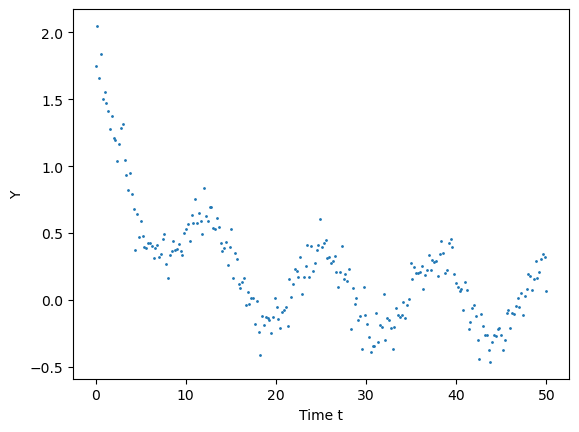

In [6]:
# define the generative parameters
a_gen = 1.5
b_gen = 8
c_gen = 0.3

# std of the random noise:
s = 0.1

T = np.linspace(0,50, 250)
Y = lambda_model(a_gen, b_gen, c_gen, T) + rng.normal(loc=0.0, scale=s, size=T.shape)
plt.plot (T, Y, '.', markersize=2)
plt.xlabel('Time t')
plt.ylabel('Y')
plt.show()

The 2-D case is:

$$
\begin{align}
   \begin{bmatrix}
           a \\
           b \\
         \end{bmatrix}_{t+1} 
         =    \begin{bmatrix}
           a \\
           b \\
         \end{bmatrix}_{t} - \alpha 
         \begin{bmatrix}
           \frac{\partial E_j}{\partial a} \\
           \frac{\partial E_j}{\partial b} \\
         \end{bmatrix} \Big\rvert _{\begin{bmatrix}
           a \\
           b \\
         \end{bmatrix}_{t} }
  \end{align}
  \\
$$

In [7]:
# This impl. is an alternative to the example where we used lambda functions.
# We reuse err_i 
# the function  returns the 3 components of the gradient AND the squared error (later used for visualization)

def calcGradErr(t, y, params):
    y_hat = lambda_model(params[0], params[1], params[2], t)
    err_i = y - y_hat
    dEda = lambda_dEda(params[0], params[1], params[2], t, y)
    dEdb = lambda_dEdb(params[0], params[1], params[2], t, y)
    dEdc = lambda_dEdc(params[0], params[1], params[2], t, y)
    return [dEda, dEdb, dEdc, err_i**2]


In [8]:
# example call. for the data point i=123 and using the generative parameters
calcGradErr(T[123], Y[123], [a_gen, b_gen, c_gen])

[-0.00234658821977044,
 -0.00135838832375642,
 -0.05022867914930761,
 0.002645522054494473]

In [9]:
%matplotlib inline

a0 = 0.5
b0 = 2.0
c0 = 0.01

a0 = 10.5
b0 = 15.0
c0 = 0.01

a0 = 1.
b0 = 3.0
c0 = 0.8


nr_iter = 100000
alpha = 0.10
alpha_min =  0.001
alpha_decay = 0.99995

# initial parameter vector
estimated_params = [a0, b0, c0]

# keep some values for visualizations:
loss = np.zeros(nr_iter)
params_history = np.zeros( (nr_iter, 3) )
alpha_t = np.zeros(nr_iter)


# simple stochastic gradient. 
for i in range(nr_iter):
    j = np.random.randint(low=0, high=T.size) # https://numpy.org/doc/stable/reference/random/generated/numpy.random.randint.html
    [dEda, dEdb, dEdc, sqErr] = calcGradErr(T[j], Y[j], estimated_params)
    grad = [dEda, dEdb, dEdc]
    estimated_params = np.subtract(estimated_params,  np.multiply(alpha, grad) )
    
    # for vizualization
    loss[i] = sqErr
    params_history[i, :]  = estimated_params
    alpha_t[i] = alpha
    
    # decay alpha
    alpha = np.max((alpha_min, alpha * alpha_decay))

print("estimated_params: {}".format(estimated_params))

estimated_params: [1.54827018 7.32051731 0.30261791]


Text(0.5, 1.0, 'validate if the fitting has converged')

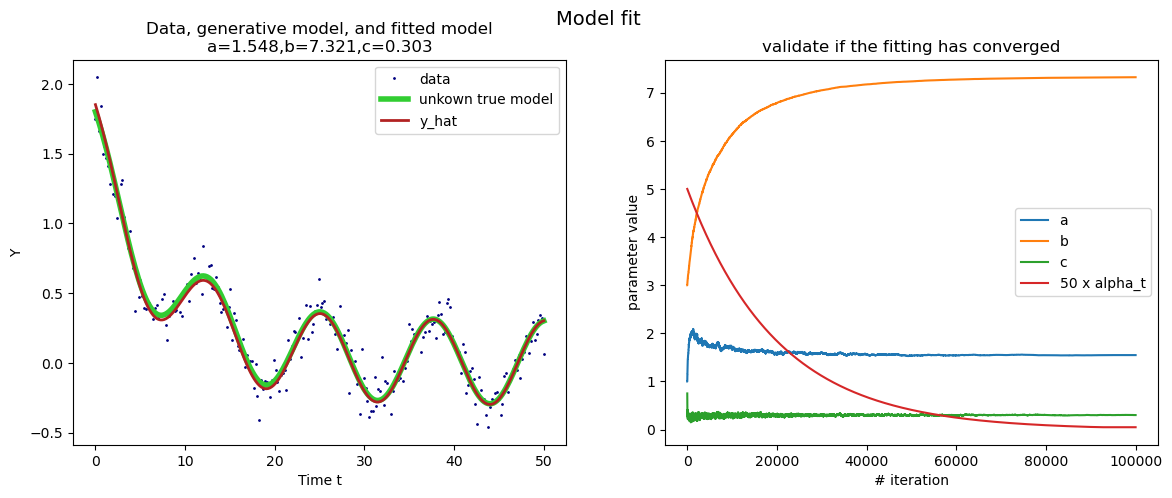

In [10]:
# use subplot to combine multiple plots in one figures
# https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html
%matplotlib inline


# fig = plt.figure()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize= (14,5))
# use axis 1 to plot the fitting result
fig.suptitle('Model fit', fontsize=14)
ax1.plot (T, Y, '.', color='navy', markersize=2, label='data')  # named colors:  https://matplotlib.org/stable/gallery/color/named_colors.html
ax1.plot (T, lambda_model(a_gen, b_gen, c_gen, T), color = 'limegreen', linewidth = 4, label = 'unkown true model',)
ax1.plot (T, lambda_model(params_history[-1, 0], params_history[-1, 1], params_history[-1, 2], T), color='firebrick', linewidth = 2, label = 'y_hat')
ax1.set_xlabel('Time t')
ax1.set_ylabel('Y')
ax1.legend()
ax1.set_title('Data, generative model, and fitted model\na={:.3f},b={:.3f},c={:.3f}'.format(estimated_params[0], estimated_params[1], estimated_params[2]))

# use axis 2 to show the trajectory
ax2.plot(params_history[:, 0], label='a')
ax2.plot(params_history[:, 1], label='b')
ax2.plot(params_history[:, 2], label='c')
ax2.plot(50*alpha_t, label='50 x alpha_t') # aplify
ax2.legend()
ax2.set_xlabel('# iteration')
ax2.set_ylabel('parameter value')
ax2.set_title('validate if the fitting has converged')

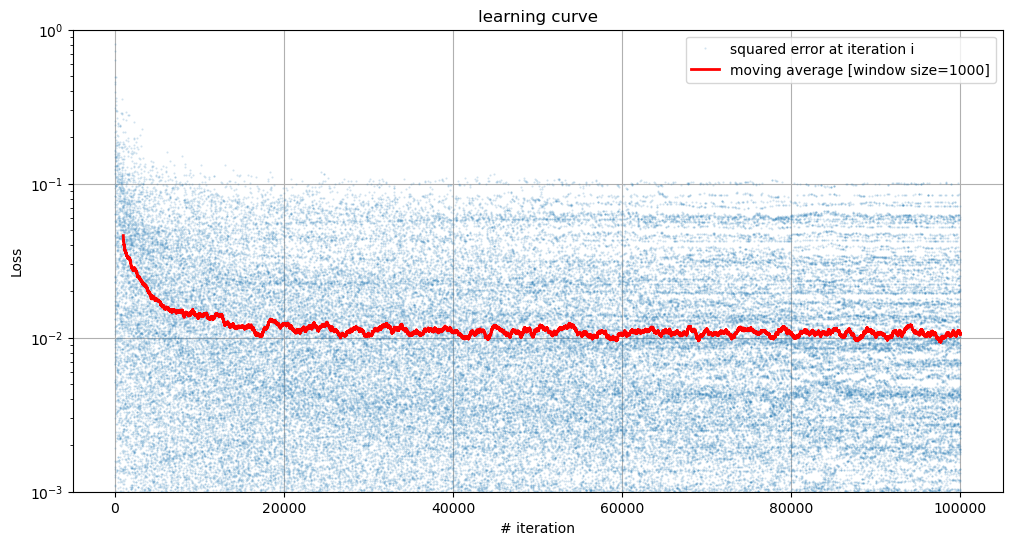

In [13]:
%matplotlib inline
plt.figure(figsize=(12,6))
plt.plot(loss, '.', markersize = 1, alpha = 0.2, label='squared error at iteration i')
plt.ylim([1e-3, 1.0,])

plt.xlabel('# iteration')
plt.ylabel('Loss')
plt.title('learning curve')
# use log space
plt.yscale('log')

# for better visualization, we use a moving average.
# https://machinelearningmastery.com/moving-average-smoothing-for-time-series-forecasting-python/
# Here we use Pandas for a very simple implementation:
import pandas as pd
df = pd.DataFrame(loss)
rolling_mean = df.rolling(window=1000).mean()
plt.plot(rolling_mean, linewidth=2, color='r', label='moving average [window size=1000]')
plt.grid()
plt.legend()
